# Polynomial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Split features/target
X_train = train.drop('Score', axis=1)
y_train = train['Score']
X_test  = test.drop('Score', axis=1)
y_test  = test['Score']

## Transformations

In [4]:
numeric_features     = ["WhiteElo", "EloDif"]
categorical_features = ["Opening_name", "Time_format", "Increment_binary"]


# numeric: scale → polynomial features
# categorical: one-hot only
numeric_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False))  
    # degree will be tuned via RandomizedSearchCV
])
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline,  numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Full modeling pipeline
model_pipeline = Pipeline([
    ("prep",   preprocessor),
    ("model",  LinearRegression())
])

## RandomSearch

In [5]:
param_distributions = {
    # tune degree of polynomial in the numeric branch
    "prep__num__poly__degree":      np.arange(1, 6),      # try degrees 1–5
    "model__fit_intercept":         [True, False]
}

In [6]:
# Configure RandomizedSearchCV
poly_search = RandomizedSearchCV(
    estimator          = model_pipeline,
    param_distributions= param_distributions,
    n_iter             = 10,               # number of param settings to sample
    cv                 = 5,                # 5-fold CV
    scoring            = "neg_mean_squared_error",
    n_jobs             = -1,
    random_state       = 42,
)

In [7]:
# Run the search
print("Starting RandomizedSearch for Polynomial Regression…")
poly_search.fit(X_train, y_train)

Starting RandomizedSearch for Polynomial Regression…


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(include_bias=False))]),
                                                                               ['WhiteElo',
                                                                                'EloDif']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('oneh

In [8]:
print(f"Best params:", poly_search.best_params_)
print(f"Poly best CV MSE: {-poly_search.best_score_:.4f}")
best_poly = poly_search.best_estimator_

Best params: {'prep__num__poly__degree': 4, 'model__fit_intercept': True}
Poly best CV MSE: 0.2262


In [9]:
# Final eval on test set
y_pred = best_poly.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.2275
Test MAE: 0.4583
Test R²:  0.0341


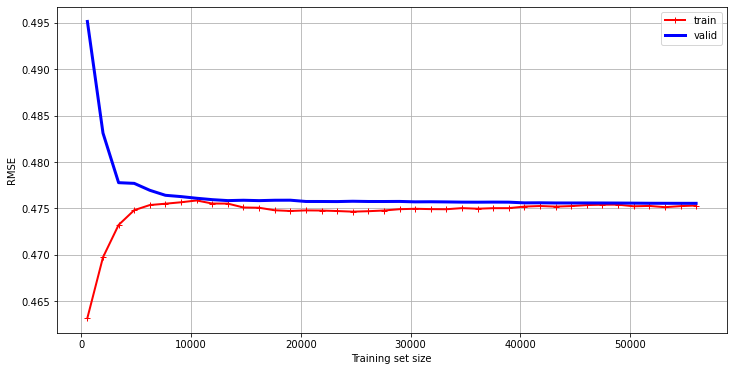

In [10]:
# Plot the learning curve for the Polynomial model
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_poly,
                                                         X_train, y_train,
                                                         train_sizes = np.linspace(0.01, 1.0, 40),
                                                         cv = 5,
                                                         scoring = "neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

fig = plt.figure(figsize = (12, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [11]:
joblib.dump(best_poly, "best_poly.joblib")

['best_poly.joblib']